# Project 5

You are a data scientist working for a Consulting Firm. You are given a dataset containing in sentiment140.csv. The data set has six columns **without header**:

0. - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
1. - the id of the tweet (2087)
2. - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
3. - the query (lyx). If there is no query, then this value is NO_QUERY.
4. - the user that tweeted (robotickilldozr)
5. - the text of the tweet ("Lyx is cool")

Data source: http://help.sentiment140.com/for-students

Our goal is to **forecast the polarity of the tweet using the text of the tweet**.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import seaborn as sns
import spacy
import string
from pprint import pprint
from time import time

from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn import preprocessing
from sklearn import svm
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

### Q1. Load the dataset of sentiment140.csv into memory.

In [2]:
Sentiment_Data = pd.read_csv('testdata.manual.2009.06.14.csv', header = None, 
                             names = ["Polarity", "ID", "Date", "Query", "User", "Text"])
Sentiment_Data.head(10)

,Polarity,ID,Date,Query,User,Text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
5,4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...
6,0,9,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non lo...
7,4,10,Mon May 11 03:26:10 UTC 2009,jquery,dcostalis,Jquery is my new best friend.
8,4,11,Mon May 11 03:27:15 UTC 2009,twitter,PJ_King,Loves twitter
9,4,12,Mon May 11 03:29:20 UTC 2009,obama,mandanicole,how can you not love Obama? he makes jokes abo...


### Q2. Clean and preprocess the texts.

Get info

In [3]:
Sentiment_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Polarity  498 non-null    int64 
 1   ID        498 non-null    int64 
 2   Date      498 non-null    object
 3   Query     498 non-null    object
 4   User      498 non-null    object
 5   Text      498 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.5+ KB


In [4]:
Missing = Sentiment_Data.isnull().sum() * 100 / len(Sentiment_Data)
Missing

Polarity    0.0
ID          0.0
Date        0.0
Query       0.0
User        0.0
Text        0.0
dtype: float64

Concatenate texts into one feature and get info

In [5]:
Columns = ["ID", "Date", "Query", "User", "Text"]
Sentiment_Data['Text'] = Sentiment_Data[Columns].apply(lambda row: ' '.join(row.values.astype(str)), axis = 1)

Sentiment_Data = Sentiment_Data[['Text', 'Polarity']]

Sentiment_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      498 non-null    object
 1   Polarity  498 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


In [6]:
Missing = Sentiment_Data.isnull().sum() * 100 / len(Sentiment_Data)
Missing

Text        0.0
Polarity    0.0
dtype: float64

Check distribution

4    0.365462
0    0.355422
2    0.279116
Name: Polarity, dtype: float64


<AxesSubplot:>

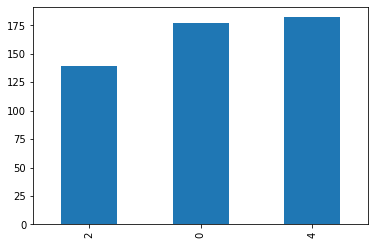

In [7]:
print(Sentiment_Data['Polarity'].value_counts(normalize= True))
Sentiment_Data.Polarity.value_counts().sort_values().plot(kind = 'bar')

Tokeniztion and Lemmatization

In [8]:
nlp = spacy.load("en_core_web_sm")

stop_words = spacy.lang.en.stop_words.STOP_WORDS

def spacy_tokenizer(sentence):
    mytokens = nlp(sentence)
    mytokens = [word.lemma_ for word in mytokens if word not in stop_words]
    return mytokens   

Create a Customized Scikit-learn Transformer

In [9]:
class features(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y = None, **fit_params):
        return self
    def get_params(self, deep = True):
        return {}

def clean_text(text):
    text = ' '.join(re.sub("(nan)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
    return text.strip().lower()   

Split Data

In [10]:
Sentiment_Data['Polarity'].value_counts(normalize = True)

4    0.365462
0    0.355422
2    0.279116
Name: Polarity, dtype: float64

In [11]:
le = preprocessing.LabelEncoder()
  
Sentiment_Data['Polarity'] = le.fit_transform(Sentiment_Data['Polarity'])
Sentiment_Data['Polarity'].value_counts(normalize = True)

2    0.365462
0    0.355422
1    0.279116
Name: Polarity, dtype: float64

In [12]:
X = Sentiment_Data['Text']
y = Sentiment_Data['Polarity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
print(f'X_train dimension: {X_train.shape}; y_train dimension: {y_train.shape}')
print(f'X_test dimension: {X_test.shape}; y_train dimension: {y_test.shape}')

X_train dimension: (398,); y_train dimension: (398,)
X_test dimension: (100,); y_train dimension: (100,)


### Q3 Build the first model based on pipeline using the support vector machine.

In [13]:
t0 = time()

tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, ngram_range = (1, 1))
classifier = svm.SVC(kernel = 'linear', C = 1.0)

pipeline = Pipeline ([("cleaner", features()), ("vectorizer", tfidf_vector), ("classifier", classifier)]) 
pipeline.fit(X_train, y_train)

print(f"It takes about {time() - t0:.1f} seconds")

It takes about 2.2 seconds


/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix (without normalization)
[[27  4  4]
 [ 5 15  8]
 [ 4  4 29]]


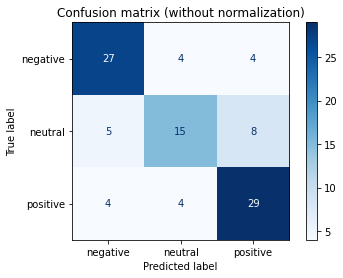

/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Normalized confusion matrix
[[0.77142857 0.11428571 0.11428571]
 [0.17857143 0.53571429 0.28571429]
 [0.10810811 0.10810811 0.78378378]]


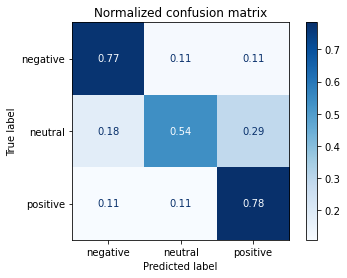

In [14]:
target_names = ['negative', 'neutral', 'positive']
titles_options = [("Confusion matrix (without normalization)", None), ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(pipeline, X_test, y_test, display_labels = target_names, 
                                 cmap = plt.cm.Blues, normalize = normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    plt.show()

In [15]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

    negative       0.75      0.77      0.76        35
     neutral       0.65      0.54      0.59        28
    positive       0.71      0.78      0.74        37

    accuracy                           0.71       100
   macro avg       0.70      0.70      0.70       100
weighted avg       0.71      0.71      0.71       100



### Q4. Check the first model. Is it a good model based on the selected evaluation metrics? Please justify your answer.

Judging by the precision, recall, and f-1 scores, the model is OK, but not great, as most of these values are only between 0.70 and 0.80. The data set is relatively balanced, so the metrics shouldn't be too misleading.

### Q5. Create the second model using pipeline, GridSearchCV for the hyperparameters for the estimators. 
(Please see all the potential parameters at  https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html and https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [16]:
pipeline = Pipeline ([("cleaner", features()), ("vectorizer", TfidfVectorizer(tokenizer = spacy_tokenizer)),
                 ("classifier", DecisionTreeClassifier())])
parameters = {'vectorizer__max_df': (0.5, 1.0), 'vectorizer__ngram_range': ((1, 1), (1,2)),
              'vectorizer__use_idf': (True, False), 'classifier__max_features': ["auto"]}
grid_search = GridSearchCV(pipeline, parameters, n_jobs = -1, verbose = 1)

print("The pipeline contains:", [name for name, _ in pipeline.steps])
print("The parameters are as follows:")
pprint(parameters)

t0 = time()
grid_search.fit(X_train, y_train)

print(f"It takes about {time() - t0:.1f} seconds.")
print()

print(f"Best score = {grid_search.best_score_:0.3f}")
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

The pipeline contains: ['cleaner', 'vectorizer', 'classifier']
The parameters are as follows:
{'classifier__max_features': ['auto'],
 'vectorizer__max_df': (0.5, 1.0),
 'vectorizer__ngram_range': ((1, 1), (1, 2)),
 'vectorizer__use_idf': (True, False)}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
It takes about 36.1 seconds.

Best score = 0.591
Best parameters set:
	classifier__max_features: 'auto'
	vectorizer__max_df: 0.5
	vectorizer__ngram_range: (1, 1)
	vectorizer__use_idf: False


### Q6. Tune the second model and perform model diagnostics. Is it a good model? Please justify your answer.

/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix (without normalization)
[[21  5  9]
 [ 7 15  6]
 [14  6 17]]


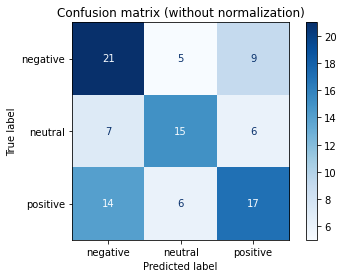

/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Normalized confusion matrix
[[0.6        0.14285714 0.25714286]
 [0.25       0.53571429 0.21428571]
 [0.37837838 0.16216216 0.45945946]]


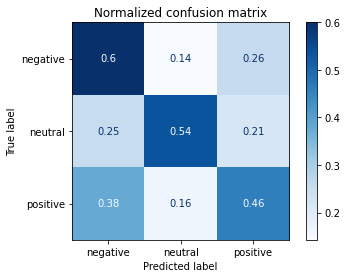

In [17]:
target_names = ['negative', 'neutral', 'positive']
titles_options = [("Confusion matrix (without normalization)", None), ("Normalized confusion matrix", 'true')]

for title, ndoormalize in titles_options:
    disp = plot_confusion_matrix(grid_search, X_test, y_test, display_labels = target_names,
                                 cmap = plt.cm.Blues, normalize = normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    plt.show()

In [18]:
y_pred = grid_search.predict(X_test)

print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

    negative       0.50      0.60      0.55        35
     neutral       0.58      0.54      0.56        28
    positive       0.53      0.46      0.49        37

    accuracy                           0.53       100
   macro avg       0.54      0.53      0.53       100
weighted avg       0.53      0.53      0.53       100



Judging by the precision, recall, and f-1 scores, the model is not that good, as most of these values are only between 0.50 and 0.60. As noted in question 4, the data set is relatively balanced, so the metrics shouldn't be too misleading.

### Q7. Build the third model using pipeline, GridSearchCV, hyperparameter for the following classifiers:
+ **Logistic regression**
+ **Support Vector Machine**
+ **Random Forest**

In [19]:
class ClfSwitcher(BaseEstimator): 
    def __init__(self, estimator = SGDClassifier()):
        self.estimator = estimator
    def fit(self, X, y = None, **kwargs):
        self.estimator.fit(X, y)
        return self
    def predict(self, X, y = None):
        return self.estimator.predict(X)
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    def score(self, X, y):
        return self.estimator.score(X, y)

In [20]:
pipeline = Pipeline ([("cleaner", features()), ("vectorizer", TfidfVectorizer()), ("classifier", ClfSwitcher())]) 

parameters = [{
        'vectorizer__tokenizer': [spacy_tokenizer],
        'vectorizer__max_df': [1.0],
        'vectorizer__norm': ('l1', 'l2'),
        'vectorizer__stop_words': ['english', None],
    
        'classifier__estimator': [LogisticRegression()],
        'classifier__estimator__solver': ['liblinear'],
        'classifier__estimator__penalty': ('l2', 'l1'),
        'classifier__estimator__max_iter': [100, 200],
        'classifier__estimator__tol': [1e-3, 1e-4] 
    },{
        'vectorizer__tokenizer': [spacy_tokenizer],
        'vectorizer__max_df': [1.0],
        'vectorizer__norm': ('l1', 'l2'),
        'vectorizer__stop_words': ['english', None],
    
        'classifier__estimator': [svm.SVC(kernel = 'linear', C = 1.0)],
        'classifier__estimator__max_iter': [-1],
        'classifier__estimator__tol': [1e-3, 1e-4]
    },{
        'vectorizer__tokenizer': [spacy_tokenizer],
        'vectorizer__max_df': [1.0],
        'vectorizer__norm': ('l1', 'l2'),
        'vectorizer__stop_words': ['english', None],
    
        'classifier__estimator': [RandomForestClassifier()],
        'classifier__estimator__random_state': [5]
    }]

print("The pipeline contains:", [name for name, _ in pipeline.steps])
print("parameters are as follows:")
pprint(parameters)

t0 = time()
gscv = GridSearchCV(pipeline, parameters, cv = 5, n_jobs = -1, return_train_score = False, verbose = 3)
gscv.fit(X_train, y_train)
print(f"It takes about {time() - t0:.3f} seconds")

The pipeline contains: ['cleaner', 'vectorizer', 'classifier']
parameters are as follows:
[{'classifier__estimator': [LogisticRegression()],
  'classifier__estimator__max_iter': [100, 200],
  'classifier__estimator__penalty': ('l2', 'l1'),
  'classifier__estimator__solver': ['liblinear'],
  'classifier__estimator__tol': [0.001, 0.0001],
  'vectorizer__max_df': [1.0],
  'vectorizer__norm': ('l1', 'l2'),
  'vectorizer__stop_words': ['english', None],
  'vectorizer__tokenizer': [<function spacy_tokenizer at 0x7f7b708740d0>]},
 {'classifier__estimator': [SVC(kernel='linear')],
  'classifier__estimator__max_iter': [-1],
  'classifier__estimator__tol': [0.001, 0.0001],
  'vectorizer__max_df': [1.0],
  'vectorizer__norm': ('l1', 'l2'),
  'vectorizer__stop_words': ['english', None],
  'vectorizer__tokenizer': [<function spacy_tokenizer at 0x7f7b708740d0>]},
 {'classifier__estimator': [RandomForestClassifier()],
  'classifier__estimator__random_state': [5],
  'vectorizer__max_df': [1.0],
  'vec

/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with 

/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with 

/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with 

/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with 

It takes about 249.105 seconds


In [21]:
print(f"Best score= {gscv.best_score_:0.3f}")

best_parameters = gscv.best_estimator_.get_params()

all_classifiers = []
for parameter in parameters:
    all_classifiers.append(parameter['classifier__estimator'])
all_classifiers = [str(alg) for clf in all_classifiers for alg in clf]
print("All potential classifiers:")
pprint(all_classifiers)

idx = all_classifiers.index(str(best_parameters['classifier__estimator']))
print("Best parameters set:")
for param_name in sorted(parameters[idx].keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score= 0.696
All potential classifiers:
["LogisticRegression(solver='liblinear', tol=0.001)",
 "SVC(kernel='linear')",
 'RandomForestClassifier()']
Best parameters set:
	classifier__estimator: LogisticRegression(solver='liblinear', tol=0.001)
	classifier__estimator__max_iter: 100
	classifier__estimator__penalty: 'l2'
	classifier__estimator__solver: 'liblinear'
	classifier__estimator__tol: 0.001
	vectorizer__max_df: 1.0
	vectorizer__norm: 'l2'
	vectorizer__stop_words: 'english'
	vectorizer__tokenizer: <function spacy_tokenizer at 0x7f7b708740d0>


###  Perform model diagnostics for the best model in Q7. Is it a good model? Please justify your answer.

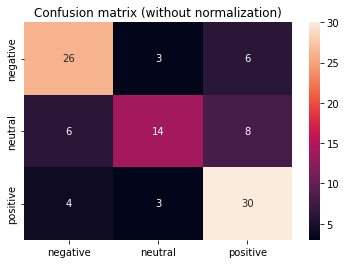

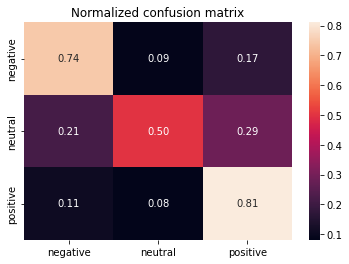

In [22]:
y_pred = gscv.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = target_names, yticklabels = target_names)
ax.set_title("Confusion matrix (without normalization)")

plt.show()

cm = cm / cm.astype(np.float64).sum(axis=1)[:,None]
ax = plt.axes()
sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = target_names, yticklabels = target_names)
ax.set_title("Normalized confusion matrix")

plt.show()

In [24]:
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

    negative       0.72      0.74      0.73        35
     neutral       0.70      0.50      0.58        28
    positive       0.68      0.81      0.74        37

    accuracy                           0.70       100
   macro avg       0.70      0.68      0.69       100
weighted avg       0.70      0.70      0.69       100



Judging by the precision, recall, and f-1 scores, the model is OK, but not great, as most of these values are only around 0.70. As noted in questions 4 and 6, the data set is relatively balanced, so the metrics shouldn't be too misleading.